In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba
import wandb

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types


from oracle_utils import AlgoResults
from sinkhorn import Sinkhorn
from transport_problem import OptimParams, DualOracle, HyperParams

In [2]:
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types
from tqdm import tqdm

from transport_problem import OptimParams, DualOracle, HyperParams

class OracleSinkhornStacker:
    def __init__(self, oracle: DualOracle, graph, sources, targets, l, w, params):
        self.k = 0
        self.oracle = oracle
        self.graph = graph
        self.sources = sources
        self.targets = targets

        self.T_LEN = oracle.edges_num
        self.LA_LEN = oracle.zones_num
        self.MU_LEN = oracle.zones_num

        # размер вектора параметров [t, la, mu]
        self.parameters_vector_size = self.T_LEN + self.LA_LEN + self.MU_LEN

        self.t = oracle.t_bar.copy()
        self.la = np.zeros(oracle.zones_num)
        self.mu = np.zeros(oracle.zones_num)
        self.optim_params = OptimParams(self.t, self.la, self.mu)
        
        self.sinkhorn = Sinkhorn(l, w, max_iter=100000, eps=1e-3)
        self.params = params

    def __call__(self, vars_block, *args, **kwargs):
        global oracle_cnt
        """
        :param vars_block: все оптимизируемые переменные stack[t, la, mu]
        :return:
        dual_value -  значение двойстенной функции для t, la, mu
        full_grad - градиент, stack[t_grad, la_grad, mu_grad]
        flows_averaged -  потоки при данных t (f)
        """
        assert len(vars_block) == self.T_LEN

        self.optim_params.t = vars_block
        self.optim_params.t = np.maximum(self.optim_params.t, self.oracle.t_bar)

        T, pred_maps = self.oracle.get_T_and_predmaps_parallel(self.optim_params, self.sources, self.targets)
        self.k += 1

        self.d, self.optim_params.la, self.optim_params.mu, k = self.sinkhorn.run(T / self.params.gamma, self.optim_params.la, self.optim_params.mu)
        flows_on_shortest = self.oracle.get_flows_on_shortest(self.sources, self.targets, self.d, pred_maps)
        grad_t = self.oracle.grad_dF_dt(self.optim_params, flows_on_shortest)
        grad_la = self.oracle.grad_dF_dla(self.d)
        grad_mu = self.oracle.grad_dF_dmu(self.d)
        grad = np.linalg.norm(np.hstack([grad_la, grad_mu]))

        full_grad = grad_t
        dual_value = self.oracle.calc_F_via_d(self.optim_params, self.d, T)

        self.flows = self.oracle.get_flows_on_shortest(self.sources, self.targets, self.d, pred_maps)

        return dual_value, full_grad, flows_on_shortest, grad, 1

    def get_prime_value(self):
        return self.oracle.prime(self.flows, self.d)

    def get_init_vars_block(self):
        return self.oracle.t_bar.copy()


# TODO: убрать unused переменные
def ustm_mincost_mcf(
        oracle_stacker: OracleSinkhornStacker,
        eps_abs: float,
        eps_cons_abs: float,
        max_iter: int = 10000,
        stop_by_crit: bool = True,
) -> tuple:
    history = AlgoResults()

    A_prev = 0.0
    
    t_start = oracle_stacker.get_init_vars_block()

    y_start = u_prev = t_prev = np.copy(t_start)
    assert y_start is u_prev

    grad_sum_prev = np.zeros(len(t_start))

    zero_dgap, grad_y, flows_averaged, grad, _ = oracle_stacker(y_start)
    sinkhorn_iters_cnt = 0
    history.history_count_calls.append(sinkhorn_iters_cnt)
    history.history_dual_gap.append(zero_dgap)
    history.history_la_mu_grad_norm.append(grad)
    print(zero_dgap, grad)
    d_avaraged = oracle_stacker.d.copy()

    L_value = np.linalg.norm(grad_y) / 10

    A = u = t = y = None
    inner_iters_num = 0

    print("start optimizing")
    for k in tqdm(range(max_iter)):
        while True:
            inner_iters_num += 1

            alpha = 0.5 / L_value + (0.25 / L_value ** 2 + A_prev / L_value) ** 0.5
            A = A_prev + alpha

            y = (alpha * u_prev + A_prev * t_prev) / A
            func_y, grad_y, flows_y, grad, sinkhorn_iter_cnt = oracle_stacker(y)
            sinkhorn_iters_cnt += sinkhorn_iter_cnt

            grad_sum = grad_sum_prev + alpha * grad_y

            u = y_start - grad_sum
            u[:oracle_stacker.T_LEN] = np.maximum(oracle_stacker.oracle.t_bar, u[:oracle_stacker.T_LEN])

            t = (alpha * u + A_prev * t_prev) / A
            func_t, _, _, grad, sinkhorn_iter_cnt = oracle_stacker(t)
            sinkhorn_iters_cnt += sinkhorn_iter_cnt

            lvalue = func_t

            rvalue = (func_y + np.dot(grad_y, t - y) + 0.5 * L_value * np.sum((t - y) ** 2) +
                      #                      0.5 * alpha / A * eps_abs )  # because, in theory, noise accumulates
                      0.5 * eps_abs)

            if lvalue <= rvalue:
                break
            else:
                L_value *= 2

            assert L_value < np.inf

            
        primal = oracle_stacker.oracle.prime(flows_averaged, d_avaraged)

        A_prev = A
        L_value /= 2

        t_prev = t
        u_prev = u
        grad_sum_prev = grad_sum

        teta = alpha / A
        flows_averaged = flows_averaged * (1 - teta) + flows_y * teta
        d_avaraged = d_avaraged * (1 - teta) + oracle_stacker.d * teta


        dgap = oracle_stacker.oracle.prime(flows_averaged, d_avaraged) + func_t
        history.history_count_calls.append(sinkhorn_iters_cnt)
        history.history_dual_gap.append(dgap)
        history.history_la_mu_grad_norm.append(grad)

        if stop_by_crit and history.history_dual_gap[-1] <= eps_abs and history.history_la_mu_grad_norm[-1] <= eps_cons_abs:
            break

    return t, history


In [3]:
# wandb.init(
#     project='TransportNetworkOptimization',
#     name='USTM_Sinkhorn',
#     entity='nik-team',
#     config={
#         'city': 'Chicago',
#     }
# )

In [4]:
BIG_CONST_FOR_FAKE_EDGES = 40

In [5]:
net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
net_df.loc[net_df.free_flow_time < 1e-6, 'free_flow_time'] = BIG_CONST_FOR_FAKE_EDGES
people_count = corrs.sum()
corrs = corrs / people_count
net_df.capacity /= people_count
net_df = net_df.rename({'free_flow_time': 'fft'}, axis=1)
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [6]:
from transport_problem import HyperParams, DualOracle, OptimParams
l = np.sum(corrs, axis=1)
l = np.maximum(l, 1e-6)
w = np.sum(corrs, axis=0)
w = np.maximum(w, 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params, net_df=net_df)
oracle_stacker = OracleSinkhornStacker(oracle, graph, sources, targets, l, w, params)

In [7]:
t, history = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-4, eps_cons_abs=1e-4, max_iter=5000, stop_by_crit=False)

51.63219956601681 4.144299002417045e-07
start optimizing


100%|███████████████████████████████████████| 5000/5000 [10:19<00:00,  8.07it/s]


In [8]:
history

AlgoResults(history_la_grad_norm=[], history_mu_grad_norm=[], history_dual_values=[], history_prime_values=[], history_dual_gap=[51.63219956601681, 15.784482374751668, 13.72462701925857, 6.69971760401166, 2.4991514475477246, 1.5929334291186734, 1.1417525496797793, 0.7490312182858361, 0.5503789928222673, 0.3901371344250961, 0.3641278465625106, 0.3291539930052636, 0.28801187555459506, 0.2517940474338687, 0.2255942867128411, 0.19604311163215726, 0.17061763358753268, 0.15543117760773129, 0.14301588270431864, 0.13388745938581081, 0.11948687069155284, 0.11287203693822079, 0.10851332592556417, 0.10406121528061618, 0.09861494634652956, 0.09476255192432603, 0.09063310094485644, 0.0865869237056458, 0.08437019858007488, 0.08116053729743555, 0.07844190476377833, 0.07595993903202469, 0.0728028322848786, 0.07117711210310063, 0.06982287646591345, 0.06812895430064003, 0.06674869842150599, 0.0652583275452514, 0.06380505529884317, 0.06226944464430062, 0.06136904044032576, 0.06018521599087023, 0.05898006

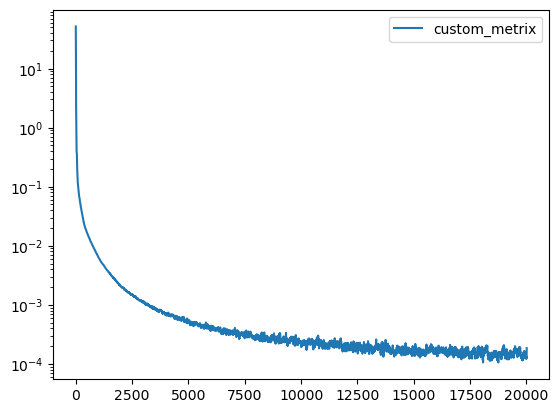

In [9]:
x = history.history_count_calls
dual_gap = history.history_dual_gap
dual_gap_clipped = np.maximum(0, dual_gap)
la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))

metric = 2 * np.array(history.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
plt.plot(x, metric, label='custom_metrix')
plt.yscale('log')
plt.legend()
plt.show()

In [55]:
# wandb.finish()

In [ ]:
# plt.plot(xs, dgap_log, label="dual gap")
# plt.legend()
# plt.yscale("log")
# plt.rcParams['figure.dpi']=300
# plt.show()


plt.plot(history_prime_values, label="history prime function")
plt.legend()
plt.show()

plt.plot(history_dual_values, label="history dual function")
plt.legend()
plt.show()

In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())

In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())